In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns;
%matplotlib inline

In [2]:
df = pd.read_csv("../data/keggs-subjects-rf-scores.csv")


In [3]:
class RatioComputer():
    ''' Compute average ratios between three different cohorts (UC, CD, LS) 
    against HE. Compute the condition number 
    
    
    Args:
    -----
    df_subjects : pandas data frame
        Data frame where we expect rows to be KEGGs with columns corresponding 
        to the cohorts HE, LS, CD, and UC. We expect the strings "HE", "LS", 
        "CD", and "UC" to be in the  header names.

    laplace_scale : float (default 1e-9)
        What value to add to ALL KEGGs to avoid division by 0 and log(0) 
        issues.
    
    random_cohort : binary (default False)
        Whether the cohorts should be randomized. Useful for hypothesis 
        testing. If random cohorts are used, then 35, 6, 7, and 15 columns are 
        randomly sampled without replacement correspondings to the cohorts HE, 
        LS, UC, and CD respectively. Thesenumbers reflect the sample sizes for 
        each cohort. 
        
    
    Attributes:
    -----------
    HE_df, LS_df, UC_df, CD_df : pandas data frames
        Pandas datafames corresponding to subject samples used for HE, LS, UC, 
        and CD cohorts.
        
    df_subjects : pandas data frame
        Subjects data frame passed that remains untouched even when 
        random_cohort = True
    
    random_cohort : binary (default True)
        If random samples where used to create HE_df, LS_df, UC_df, and CD_df. 
        
        
    Example:
    --------
    >>> # read data
    >>> df = pd.read_csv("../data/keggs-subjects-rf-scores.csv")
    >>> mean_ratios = RatioComputer(df_subjects = df.iloc[:,2:])
    >>> mean_ratios.mean_ratios_cond_number(laplace_scale_numerator=False)

    
    '''
    def __init__(self, df_subjects, laplace_scale = 1e-9,
                 random_cohort = False):
        self.df_subjects = df_subjects
        self.random_cohort = random_cohort
        self.laplace_scale = laplace_scale
        
        if self.random_cohort:
            df_random = df_subjects.iloc[:,np.random.permutation(np.arange(df_subjects.shape[1]))]
            self.HE_df = df_random.iloc[:,:35]
            self.LS_df = df_random.iloc[:,35:(35+7)]
            self.UC_df = df_random.iloc[:,(35+7):(35+7+6)]
            self.CD_df = df_random.iloc[:,(35+7+6):]
            
        else:
            self.HE_df = df_subjects.filter(regex=("HE.*"))
            self.LS_df = df_subjects.filter(regex=("LS.*"))
            self.UC_df = df_subjects.filter(regex=("UC.*"))
            self.CD_df = df_subjects.filter(regex=("CD.*"))
            

            
    def return_eig_vals(self):
        self.ratio_matrix_finite = self.ratio_matrix[:,np.all(np.isfinite(self.ratio_matrix), 
                                                              axis=0)]      
        self.ratio_matrix_cov = np.cov(self.ratio_matrix_finite)
        w, v = np.linalg.eig(self.ratio_matrix_cov)  
        return w    
    
    
    def mean_ratios_cond_number(self, normalize = False, 
                                laplace_scale_numerator = True):
        ''' compute mean KEGG for each KEGG for each cohort, then take the 
        log-ratio of the average KEGG for cohorts LS, CD, and UC against HE to 
        yeild the tuple (LS/HE, UC/HE, CD/HE). Can think of this tuple as a 
        matrix with 3 columns corresponding to the 3 ratios and ~10K rows 
        corresponding to each KEGG. We compute the condition number for 3x3 
        covariance matrix formed by this tuple. 
        
        
        Args:
        -----
        normalize : binary (default False)
            Whether the *averaged* relative abundances should be normalized 
            so that  all KEGGs add to 1.0 after averaging has been computed. 
        
        laplace_scale_numerator : binary (default True)
            Whether the numerator of the ratio should also be laplaced scale 
            in addition to the denominator. When laplace_scale_numerator=True
            the ratios are computed as:
            
                        a_b = np.log10((a + laplace_scale)/(b + laplace_scale)
            
            This handles division by 0 errors (when b = 0) and log(0) errors 
            (when a = 0). If laplace_scale_numerator=False, then the ratios 
            are computed as:
                       
                       a_b = np.log10(a/(b + laplace_scale) 
            
            In other words, NaNs will be introduced for cases when a = 0 since
            np.log10(0) is -inf
        
        '''
                    
        with np.errstate(divide='ignore'):
            self.HE_mean = self.HE_df.apply(lambda x: 10**np.nanmean(np.log10(x)), 
                                       axis = 1)
            self.LS_mean = self.LS_df.apply(lambda x: 10**np.nanmean(np.log10(x)), 
                                       axis = 1)
            self.UC_mean = self.UC_df.apply(lambda x: 10**np.nanmean(np.log10(x)), 
                                       axis = 1)
            self.CD_mean = self.CD_df.apply(lambda x: 10**np.nanmean(np.log10(x)), 
                                       axis = 1)
        
        if normalize:
            self.HE_mean = self.HE_mean/np.nansum(self.HE_mean)
            self.LS_mean = self.LS_mean/np.nansum(self.LS_mean)
            self.CD_mean = self.CD_mean/np.nansum(self.CD_mean)
            self.UC_mean = self.UC_mean/np.nansum(self.UC_mean)
            
        if laplace_scale_numerator:    
            self.LS_HE_mean = np.log10((self.LS_mean+self.laplace_scale)/(self.HE_mean+self.laplace_scale))
            self.UC_HE_mean = np.log10((self.UC_mean+self.laplace_scale)/(self.HE_mean+self.laplace_scale))
            self.CD_HE_mean = np.log10((self.CD_mean+self.laplace_scale)/(self.HE_mean+self.laplace_scale))
        else:
            with np.errstate(divide='ignore'):
                self.LS_HE_mean = np.log10((self.LS_mean)/(self.HE_mean+self.laplace_scale))
                self.UC_HE_mean = np.log10((self.UC_mean)/(self.HE_mean+self.laplace_scale))
                self.CD_HE_mean = np.log10((self.CD_mean)/(self.HE_mean+self.laplace_scale))
            
        self.ratio_matrix = np.array([self.LS_HE_mean, self.UC_HE_mean, self.CD_HE_mean])
        
        w = self.return_eig_vals()
        self.cond_number = np.max(w)/np.min(w) 
        return self.cond_number   

    def median_ratios_cond_number(self, laplace_scale = 1e-9, normalize = False, laplace_scale_numerator = True):
        HE_median = self.HE_df.apply(lambda x: np.median(x), axis = 1)
        LS_median = self.LS_df.apply(lambda x: np.median(x), axis = 1)
        UC_median = self.UC_df.apply(lambda x: np.median(x), axis = 1)
        CD_median = self.CD_df.apply(lambda x: np.median(x), axis = 1)
        
        if normalize:
            HE_median = HE_median/np.sum(HE_median)
            LS_median = LS_median/np.sum(LS_median)
            CD_median = CD_median/np.sum(CD_median)
            UC_median = UC_median/np.sum(UC_median)
        
        if laplace_scale_numerator:
            self.LS_HE_median = np.log10((LS_median+self.laplace_scale)/(HE_median+self.laplace_scale))
            self.UC_HE_median = np.log10((UC_median+self.laplace_scale)/(HE_median+self.laplace_scale))
            self.CD_HE_median = np.log10((CD_median+self.laplace_scale)/(HE_median+self.laplace_scale))
        else:
            with np.errstate(divide='ignore'):
                self.LS_HE_median = np.log10((LS_median)/(HE_median+self.laplace_scale))
                self.UC_HE_median = np.log10((UC_median)/(HE_median+self.laplace_scale))
                self.CD_HE_median = np.log10((CD_median)/(HE_median+self.laplace_scale))            
            
        self.ratio_matrix = np.array([self.LS_HE_median, self.UC_HE_median, self.CD_HE_median])  
        
        w = self.return_eig_vals()
        self.cond_number = np.max(w)/np.min(w)  
        return self.cond_number
    
    def plot_mean_ratios(self):
        plt.subplot(1,3,1)
        plt.plot(self.LS_HE_mean, self.CD_HE_mean, '.')
        plt.xlabel("LS to HE")
        plt.ylabel("CD to HE")

        plt.subplot(1,3,2)
        plt.plot(self.LS_HE_mean, self.UC_HE_mean, '.')
        plt.xlabel("LS to HE")
        plt.ylabel("UC to HE")
        
        plt.subplot(1,3,3)
        plt.plot(self.UC_HE_mean, self.CD_HE_mean, '.')
        plt.xlabel("UC to HE")
        plt.ylabel("CD to HE")
        
        
    def plot_median_ratios(self):
        plt.subplot(1,3,1)
        plt.plot(self.LS_HE_median, self.CD_HE_median, '.')
        plt.xlabel("LS to HE")
        plt.ylabel("CD to HE")

        plt.subplot(1,3,2)
        plt.plot(self.LS_HE_median, self.UC_HE_median, '.')
        plt.xlabel("LS to HE")
        plt.ylabel("UC to HE")
        
        plt.subplot(1,3,3)
        plt.plot(self.UC_HE_median, self.CD_HE_median, '.')
        plt.xlabel("UC to HE")
        plt.ylabel("CD to HE")

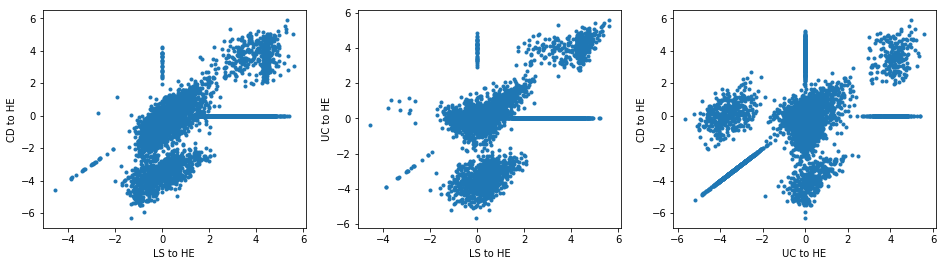

In [4]:
median_ratios = RatioComputer(df_subjects = df.iloc[:,2:])
cohort_cond_number = median_ratios.median_ratios_cond_number(laplace_scale_numerator=True, normalize=True)

plt.figure(figsize=(16, 4))
median_ratios.plot_median_ratios()

In [5]:
df_cohort_ratios = pd.DataFrame(np.vstack((median_ratios.LS_HE_median, median_ratios.CD_HE_median, median_ratios.UC_HE_median)).T)

df_cohort_ratios.columns = ["LS_HE", "CD_HE", "UC_HE"]

df_cohort_ratios["kegg"] = df.kegg

In [6]:
df_cohort_ratios.head()

,LS_HE,CD_HE,UC_HE,kegg
0,0.232002,0.138432,0.063712,K00001(alcohol_dehydrogenase)
1,0.394706,0.688428,-0.059959,K00002(alcohol_dehydrogenase_(NADP+))
2,0.476956,0.610852,-0.173077,K00003(homoserine_dehydrogenase)
3,0.709239,0.735587,-0.012324,"K00004((R,R)-butanediol_dehydrogenase_/_diacet..."
4,0.755915,0.688222,0.182877,K00005(glycerol_dehydrogenase)


In [7]:
def viz_stuff(df_subset):
    

    plt.subplot(1,3,1)
    plt.plot(df_subset.LS_HE, df_subset.CD_HE, '.')
    plt.xlabel("LS to HE")
    plt.ylabel("CD to HE")

    plt.subplot(1,3,2)
    plt.plot(df_subset.LS_HE, df_subset.UC_HE, '.')
    plt.xlabel("LS to HE")
    plt.ylabel("UC to HE")

    plt.subplot(1,3,3)
    plt.plot(df_subset.UC_HE, df_subset.CD_HE, '.')
    plt.xlabel("UC to HE")
    plt.ylabel("CD to HE")
    
    
def prep_group_keggs(indices):
    df_group = df_cohort_ratios[indices]
    
    df_group_merged = pd.merge(df_group, df)
    
    df_group_merged.index = df_group_merged.kegg
    
    return df_group, df_group_merged

## Group 7

In [8]:
# group_7_df = df_cohort_ratios[(df_cohort_ratios.LS_HE >0 ) & (df_cohort_ratios.UC_HE < -2) 
#                              & (df_cohort_ratios.CD_HE > -2)]

group_7_df, df_res_group_7_df = prep_group_keggs((df_cohort_ratios.LS_HE >0 ) & (df_cohort_ratios.UC_HE < -2) 
                                                 & (df_cohort_ratios.CD_HE > -2))

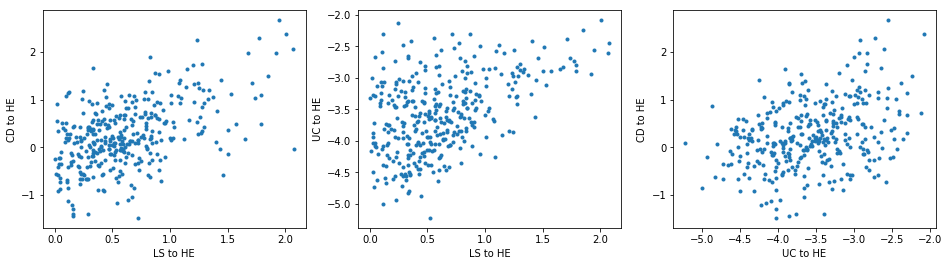

In [9]:
plt.figure(figsize=(16, 4))

viz_stuff(group_7_df)

In [10]:
df_res_group_7_df.shape

(349, 68)

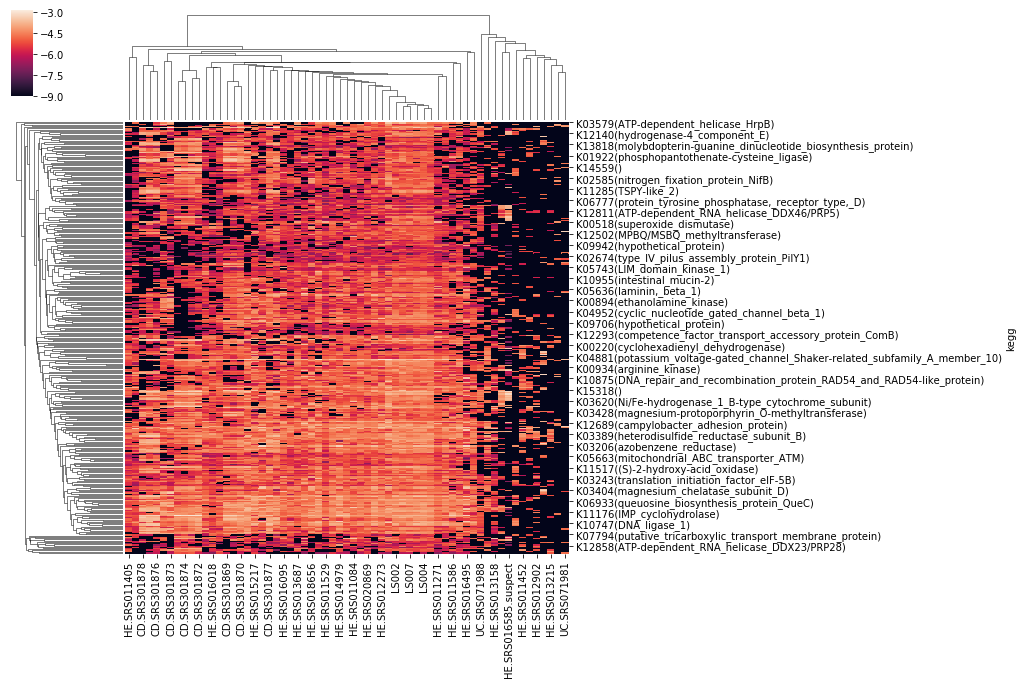

In [10]:
sns.clustermap(np.log10(1e-9+df_res_group_7_df.iloc[:,5:]));

In [27]:
df_res_group_7_df.iloc[:,26:34].sample(10)

,CD.SRS301879,UC.SRS071964,UC.SRS071970,UC.SRS071978,UC.SRS071981,UC.SRS071982,UC.SRS071988,HE.SRS011061
kegg,,,,,,,,
K01479(formiminoglutamase),8.568862e-06,0.000000,0.00000,0.000000,0.0,0.000000,0.000000e+00,0.000000
"K10702(2-hydroxy-6-oxohepta-2,4-dienoate_hydroxylase)",0.000000e+00,0.000418,0.00000,0.000000,0.0,0.000000,1.019582e-05,0.000000
K12370(dipeptide_transport_system_permease_protein),1.238266e-05,0.000000,0.00000,0.000000,0.0,0.000095,3.006903e-05,0.000029
K06792(aggrecan_1),1.794899e-06,0.000000,0.00000,0.000000,0.0,0.000000,0.000000e+00,0.000005
K01597(diphosphomevalonate_decarboxylase),2.936641e-05,0.000000,0.00001,0.000021,0.0,0.000000,0.000000e+00,0.000000
K03405(magnesium_chelatase_subunit_I),1.438986e-07,0.000532,0.00000,0.000000,0.0,0.000000,2.375405e-06,0.000032
K09935(hypothetical_protein),2.633263e-05,0.000000,0.00000,0.000000,0.0,0.000051,1.655049e-05,0.000058
K14708(),1.724798e-05,0.000000,0.00001,0.000000,0.0,0.000000,0.000000e+00,0.000000
K13819(NifU-like_protein),3.658605e-06,0.000006,0.00000,0.000000,0.0,0.000000,1.281323e-06,0.000000


In [11]:
#df_res_group_7_df.to_csv("keggs_group_7.csv", index = False)

## Group 3

In [12]:
# group_3_df = df_cohort_ratios[(df_cohort_ratios.UC_HE < -2) & (df_cohort_ratios.LS_HE > -2) &
#                               (df_cohort_ratios.CD_HE < -2)]

group_3_df, df_res_group_3_df = prep_group_keggs((df_cohort_ratios.UC_HE < -2) & (df_cohort_ratios.LS_HE > -2) &
                                                 (df_cohort_ratios.CD_HE < -2))

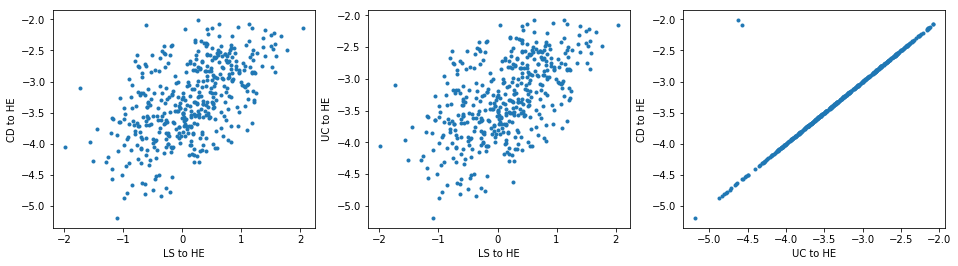

In [13]:
plt.figure(figsize=(16, 4))

#viz_stuff(group_3_df.iloc[:,:3])
viz_stuff(group_3_df)

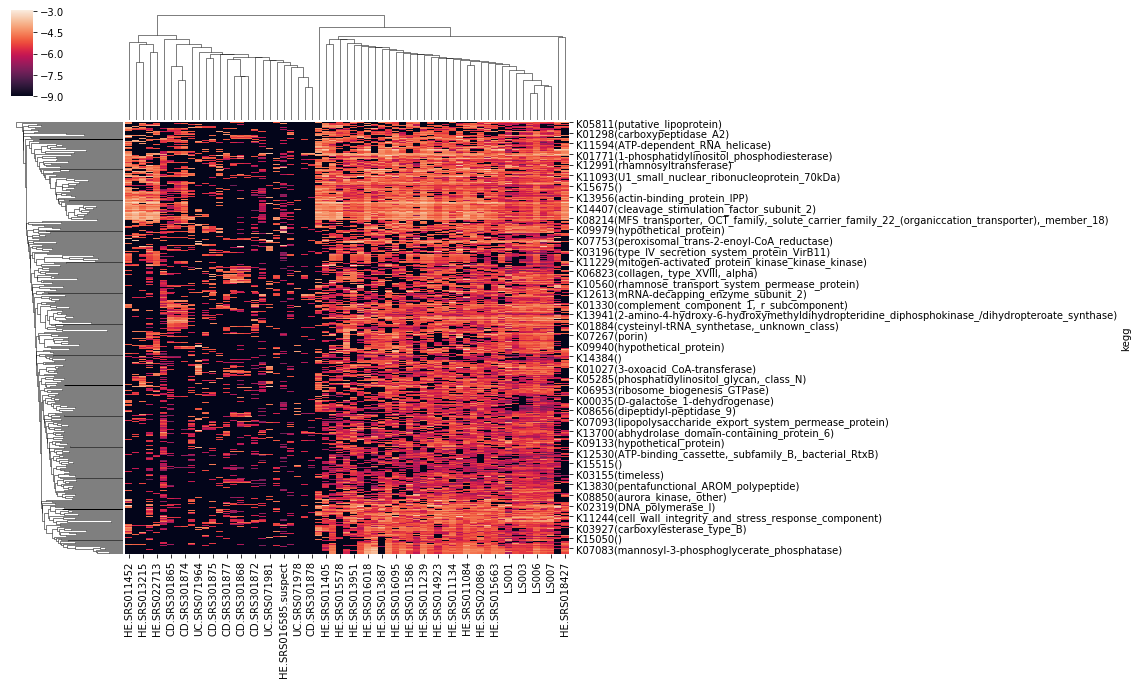

In [14]:
sns.clustermap(np.log10(1e-9+df_res_group_3_df.iloc[:,5:]))

In [15]:
#df_res_group_3_df.to_csv("keggs_group_3.csv", index = False)

## Group 2

In [16]:
group_2_df, df_res_group_2_df = prep_group_keggs((df_cohort_ratios.UC_HE > 2) & (df_cohort_ratios.LS_HE > 2) &
                                                 (df_cohort_ratios.CD_HE >2))

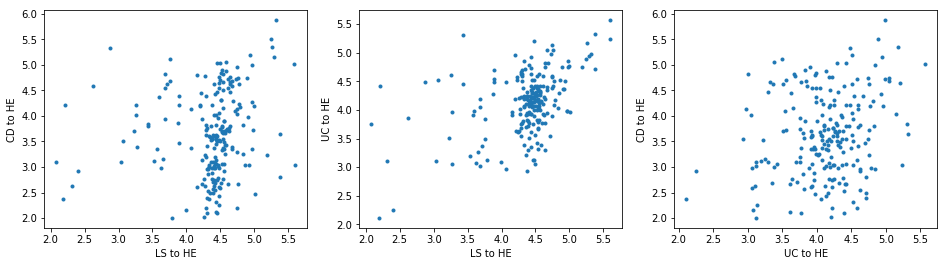

In [17]:
plt.figure(figsize=(16, 4))

viz_stuff(group_2_df)

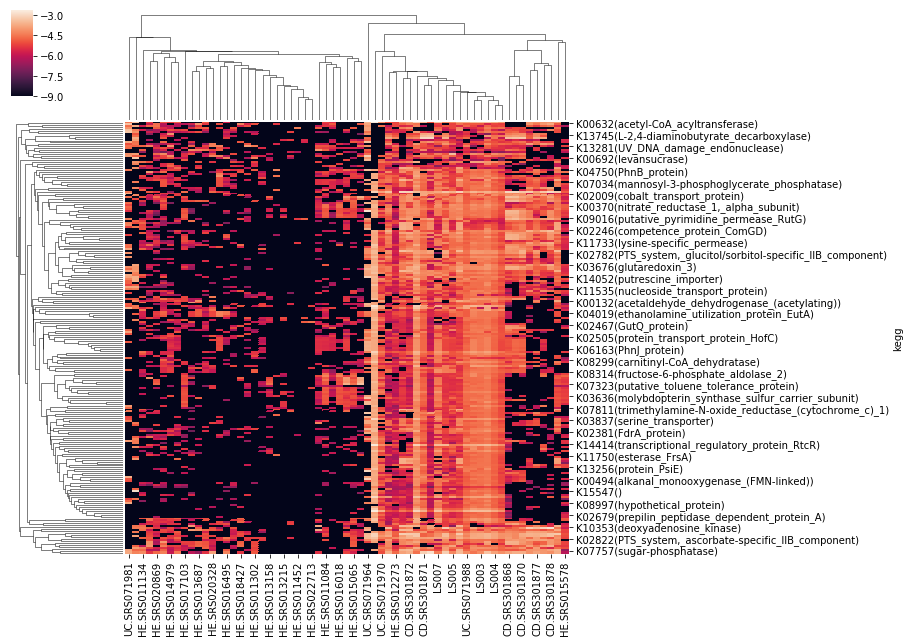

In [18]:
sns.clustermap(np.log10(1e-9+df_res_group_2_df.iloc[:,5:]))

In [19]:
df_res_group_2_df.to_csv("keggs_group_2.csv", index = False)

## Groups 4 & 5

In [20]:
group_5_df, df_res_group_5_df = prep_group_keggs((df_cohort_ratios.UC_HE == 0) | (df_cohort_ratios.LS_HE == 0) |
                                                 (df_cohort_ratios.CD_HE == 0))

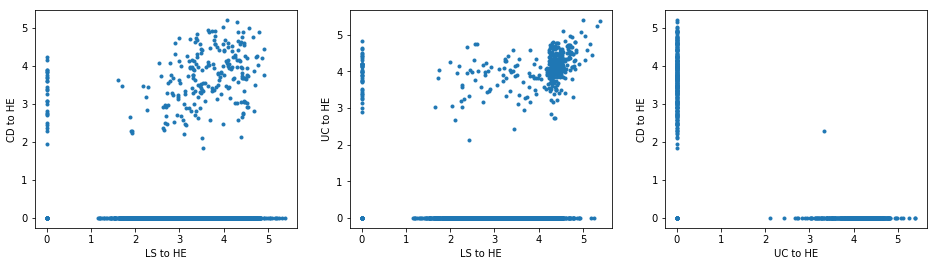

In [21]:
plt.figure(figsize=(16, 4))

viz_stuff(group_5_df)

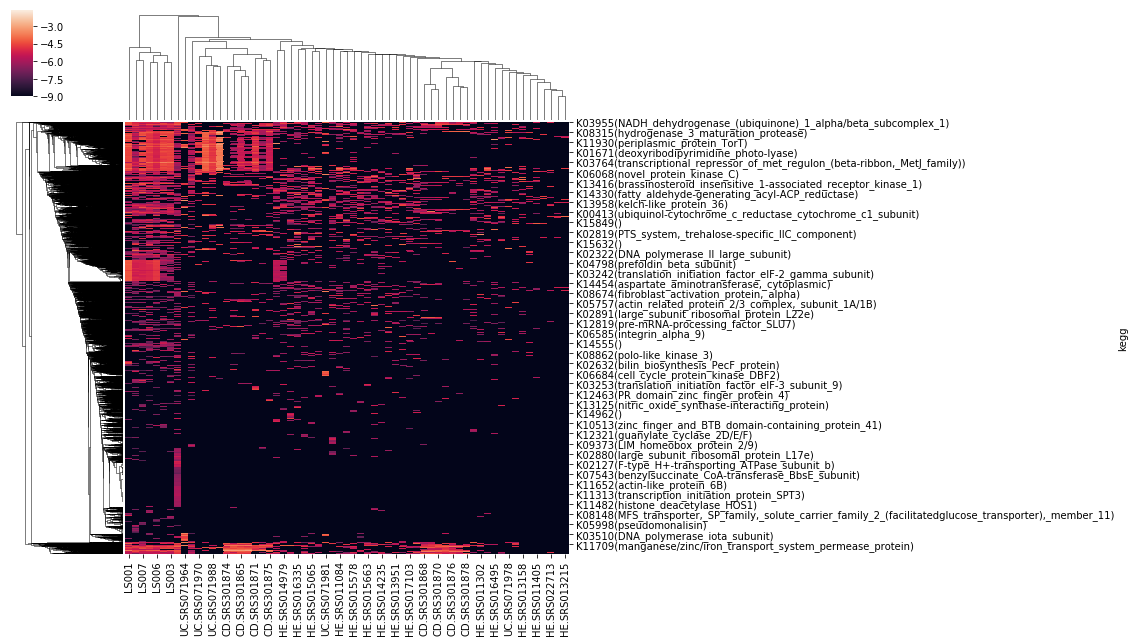

In [22]:
sns.clustermap(np.log10(1e-9+df_res_group_5_df.iloc[:,5:]));

In [23]:
df_res_group_5_df.to_csv("keggs_group_4_5.csv", index = False)

## Group 6

In [28]:
group_6_df, df_res_group_6_df = prep_group_keggs((df_cohort_ratios.UC_HE == df_cohort_ratios.CD_HE) | (df_cohort_ratios.LS_HE == df_cohort_ratios.CD_HE) |
                                                 (df_cohort_ratios.UC_HE == df_cohort_ratios.LS_HE))

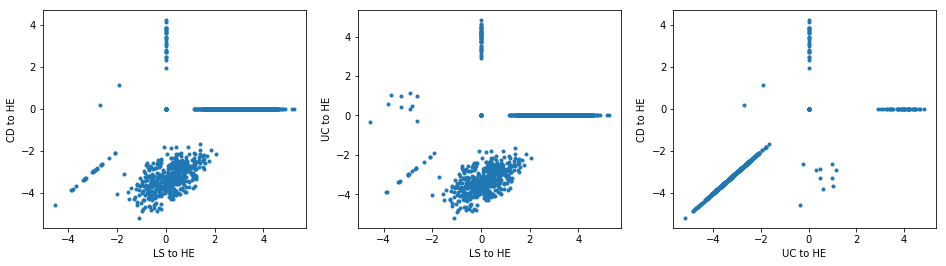

In [29]:
plt.figure(figsize=(16, 4))

viz_stuff(group_6_df)

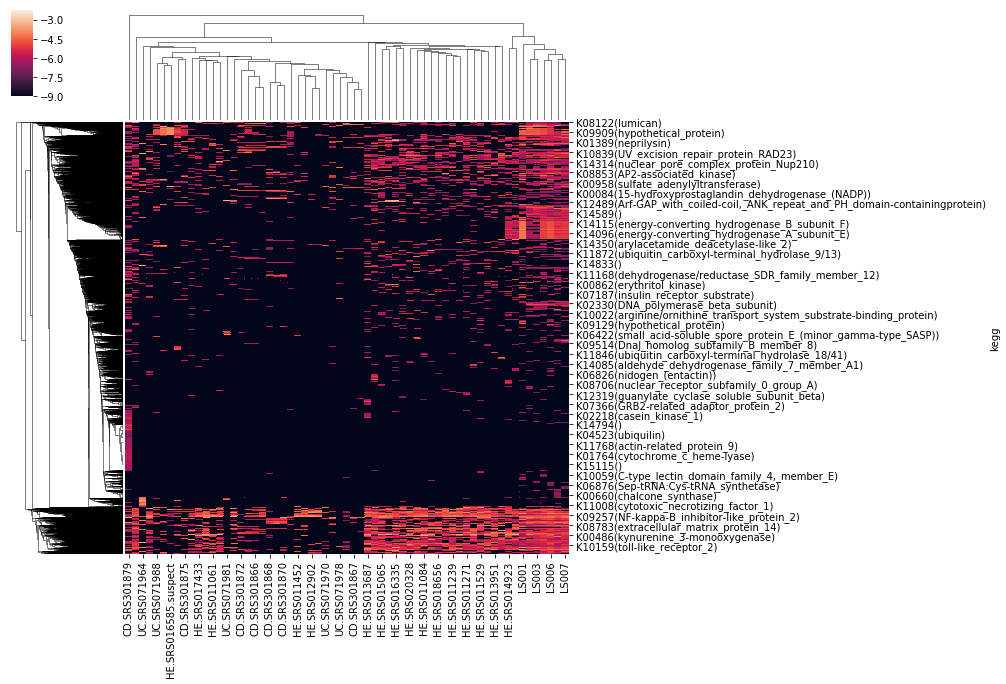

In [26]:
sns.clustermap(np.log10(1e-9+df_res_group_6_df.iloc[:,5:]));

In [27]:
df_res_group_6_df.to_csv("keggs_group_6.csv", index = False)

In [44]:
df[df.kegg.str.contains("K00247")].values[:,2:]

array([[0.000179388493338387, 0.000176792817413483, 0.000164788331916376,
        9.5714919913443e-05, 1.49948587589012e-05,
        4.4203272695505896e-05, 0.00020216315846090902,
        2.1817908253982198e-05, 7.648125215273121e-06, 0.0, 0.0, 0.0,
        0.0, 0.000128402785846331, 0.0, 5.2954872175461305e-06, 0.0,
        2.8904680439862603e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.000382352570752011, 0.000106963810640999, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.87874923348213e-06, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0696614787153098e-05,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.00130022889976891]], dtype=object)

In [45]:
df.columns[2:]

Index(['LS001', 'LS002', 'LS003', 'LS004', 'LS005', 'LS006', 'LS007',
       'CD.SRS301865', 'CD.SRS301866', 'CD.SRS301867', 'CD.SRS301868',
       'CD.SRS301869', 'CD.SRS301870', 'CD.SRS301871', 'CD.SRS301872',
       'CD.SRS301873', 'CD.SRS301874', 'CD.SRS301875', 'CD.SRS301876',
       'CD.SRS301877', 'CD.SRS301878', 'CD.SRS301879', 'UC.SRS071964',
       'UC.SRS071970', 'UC.SRS071978', 'UC.SRS071981', 'UC.SRS071982',
       'UC.SRS071988', 'HE.SRS011061', 'HE.SRS011084', 'HE.SRS011134',
       'HE.SRS011239', 'HE.SRS011271', 'HE.SRS011302', 'HE.SRS011405',
       'HE.SRS011452', 'HE.SRS011529', 'HE.SRS011586', 'HE.SRS012273',
       'HE.SRS012902', 'HE.SRS013158', 'HE.SRS013215', 'HE.SRS013687',
       'HE.SRS013951', 'HE.SRS014235', 'HE.SRS014923', 'HE.SRS014979',
       'HE.SRS015065', 'HE.SRS015217', 'HE.SRS015578', 'HE.SRS015663',
       'HE.SRS016018', 'HE.SRS016095', 'HE.SRS016335', 'HE.SRS016495',
       'HE.SRS017103', 'HE.SRS017433', 'HE.SRS018427', 'HE.SRS018656',
       

In [48]:
pd.DataFrame({"patient": df.columns[2:], "kegg_value": df[df.kegg.str.contains("K00247")].values[:,2:].squeeze()})

,kegg_value,patient
0,0.000179388,LS001
1,0.000176793,LS002
2,0.000164788,LS003
3,9.57149e-05,LS004
4,1.49949e-05,LS005
5,4.42033e-05,LS006
6,0.000202163,LS007
7,2.18179e-05,CD.SRS301865
8,7.64813e-06,CD.SRS301866
9,0,CD.SRS301867
